In [1]:
import transformers
print(transformers.__version__)
from transformers import TrainingArguments
help(TrainingArguments)


4.52.4
Help on class TrainingArguments in module transformers.training_args:

class TrainingArguments(builtins.object)
 |  TrainingArguments(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_ut

In [2]:
# IMDB dataset path
imdb_csv = "/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"

# Bengali dataset TXT paths
pos_file = "/kaggle/input/bengali-sentiment-classification/all_positive_8500.txt"
neg_file = "/kaggle/input/bengali-sentiment-classification/all_negative_3307.txt"

# Convert Bangla TXT -> CSV
import pandas as pd, os
with open(pos_file, "r", encoding="utf-8") as f:
    pos_lines = f.read().splitlines()
with open(neg_file, "r", encoding="utf-8") as f:
    neg_lines = f.read().splitlines()

df_pos = pd.DataFrame({"text": pos_lines, "label": 1})
df_neg = pd.DataFrame({"text": neg_lines, "label": 0})
df_bn = pd.concat([df_pos, df_neg], ignore_index=True)

# Save CSV locally so rest of pipeline can use it
os.makedirs("data/bn", exist_ok=True)
bn_csv = "data/bn/bengali_sentiment.csv"
df_bn.to_csv(bn_csv, index=False, encoding="utf-8")

print("IMDB CSV:", imdb_csv)
print("Bengali CSV created:", bn_csv)


IMDB CSV: /kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
Bengali CSV created: data/bn/bengali_sentiment.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split  # ✅ required import

def normalize_en_label(x):
    s = str(x).strip().lower()
    if s in ['pos','positive','1','true','yes']:
        return 1
    if s in ['neg','negative','0','false','no']:
        return 0
    try:
        v = int(float(s))
        return 1 if v > 0 else 0
    except:
        pass
    raise ValueError(f"Unrecognized English label: {x}")

def normalize_bn_label(x):
    s = str(x).strip().lower()
    if s in ['positive','pos','1','true','yes','পজিটিভ','ইতিবাচক']:
        return 1
    if s in ['negative','neg','0','false','no','নেগেটিভ','নেতিবাচক']:
        return 0
    try:
        v = int(float(s))
        return 1 if v == 1 else 0
    except:
        pass
    raise ValueError(f"Unrecognized Bengali label: {x}")

# English dataset
df_en = pd.read_csv(imdb_csv)
if "review" not in df_en.columns:
    for cand in ["text", "content", "review_text", "Review"]:
        if cand in df_en.columns:
            df_en = df_en.rename(columns={cand: "review"})
if "sentiment" not in df_en.columns:
    for cand in ["label", "target", "Sentiment"]:
        if cand in df_en.columns:
            df_en = df_en.rename(columns={cand: "sentiment"})

df_en["label"] = df_en["sentiment"].apply(normalize_en_label)
df_en = df_en[["review", "label"]].rename(columns={"review": "text"})
en_train, en_dev = train_test_split(
    df_en, test_size=0.2, random_state=42, stratify=df_en["label"]
)

# Bengali dataset
df_bn = pd.read_csv(bn_csv)
if "label" not in df_bn.columns:
    # Already has text+label from TXT conversion, no normalization needed
    pass
else:
    text_col = next(
        (c for c in ["text", "content", "comment", "sentence", "review", "tweet", "Text"] if c in df_bn.columns),
        None
    )
    label_col = next(
        (c for c in ["label", "sentiment", "target", "polarity", "class", "Sentiment"] if c in df_bn.columns),
        None
    )
    df_bn = df_bn[[text_col, label_col]].rename(columns={text_col: "text", label_col: "raw_label"})
    df_bn["label"] = df_bn["raw_label"].apply(normalize_bn_label)
    df_bn = df_bn[["text", "label"]]

print("English train/dev sizes:", en_train.shape, en_dev.shape)
print("Bengali test size:", df_bn.shape)


English train/dev sizes: (40000, 2) (10000, 2)
Bengali test size: (11807, 2)


In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

baseline_clf = make_pipeline(TfidfVectorizer(max_features=20000, ngram_range=(1,2)), DummyClassifier(strategy="most_frequent"))
baseline_clf.fit(df_bn['text'], df_bn['label'])
bn_pred_base = baseline_clf.predict(df_bn['text'])

bn_baseline_acc = accuracy_score(df_bn['label'], bn_pred_base)
print("BN baseline accuracy:", bn_baseline_acc)
print(classification_report(df_bn['label'], bn_pred_base, digits=4))


BN baseline accuracy: 0.7199119166596087
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      3307
           1     0.7199    1.0000    0.8371      8500

    accuracy                         0.7199     11807
   macro avg     0.3600    0.5000    0.4186     11807
weighted avg     0.5183    0.7199    0.6027     11807



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
from transformers import XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ✅ Always load from Kaggle dataset path (offline model)
model_path = "/kaggle/input/xlm-roberta-base-pytorch-model/xlm-roberta-base_pytorch_model"

tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_path)

id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

model = XLMRobertaForSequenceClassification.from_pretrained(
    model_path,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Tokenize datasets
train_ds = Dataset.from_pandas(en_train.reset_index(drop=True))
dev_ds   = Dataset.from_pandas(en_dev.reset_index(drop=True))

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=256)

train_tok = train_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in train_ds.column_names if c not in ["text","label"]])
dev_tok   = dev_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in dev_ds.column_names if c not in ["text","label"]])

# ✅ Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# ✅ Training args (modern API works in 4.52.4)
training_args = TrainingArguments(
    output_dir="./results",
   eval_strategy="epoch",     # ✅ correct key
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    disable_tqdm=False,   # ✅ progress bar ON
    report_to="none"
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# ✅ Run training
train_out = trainer.train()
print("Training complete. Best checkpoint:", trainer.state.best_model_checkpoint)


2025-09-21 07:15:29.755406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758438930.084445      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758438930.177317      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/xlm-roberta-base-pytorch-model/xlm-roberta-base_pytorch_model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/tmp/ipykernel_36/2347550879.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.222600,0.203126,0.921400,0.906600,0.939600,0.922805


Training complete. Best checkpoint: ./results/checkpoint-1250


In [8]:
dev_metrics = trainer.evaluate(eval_dataset=dev_tok)
print("EN Dev metrics:", dev_metrics)
en_dev_acc = dev_metrics.get("eval_accuracy", None)


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


EN Dev metrics: {'eval_loss': 0.2031257301568985, 'eval_accuracy': 0.9214, 'eval_precision': 0.9065997684291779, 'eval_recall': 0.9396, 'eval_f1': 0.9228049499116087, 'eval_runtime': 90.2678, 'eval_samples_per_second': 110.781, 'eval_steps_per_second': 1.739, 'epoch': 1.0}


In [11]:
# --- Make sure bn_tok exists, then evaluate on BN ---

import os, pandas as pd
from datasets import Dataset

# 1) Ensure we have a tokenize_fn
if "tokenize_fn" not in globals():
    def tokenize_fn(batch):
        return tokenizer(batch["text"], truncation=True, max_length=256)

# 2) Build df_bn if it's not already in memory
if "df_bn" not in globals():
    # Try the Kaggle Bangla sentiment files you mentioned
    pos_txt = "/kaggle/input/bengali-sentiment-classification/all_positive_8500.txt"
    neg_txt = "/kaggle/input/bengali-sentiment-classification/all_negative_3307.txt"

    if os.path.exists(pos_txt) and os.path.exists(neg_txt):
        pos = pd.read_csv(pos_txt, header=None, names=["text"])
        pos["label"] = 1
        neg = pd.read_csv(neg_txt, header=None, names=["text"])
        neg["label"] = 0
        df_bn = pd.concat([pos, neg], ignore_index=True)
    else:
        raise FileNotFoundError(
            "Bangla files not found. Expected:\n"
            f"  {pos_txt}\n  {neg_txt}\n"
            "If you have a CSV instead, load it into df_bn with columns ['text','label'] before running this cell."
        )

# 3) Create HF Dataset and tokenize
bn_ds  = Dataset.from_pandas(df_bn.reset_index(drop=True))
bn_tok = bn_ds.map(
    tokenize_fn,
    batched=True,
    remove_columns=[c for c in bn_ds.column_names if c not in ["text", "label"]],
)

# 4) Evaluate
bn_metrics = trainer.evaluate(eval_dataset=bn_tok)
print("BN Test metrics:", bn_metrics)

bn_test_acc = bn_metrics.get("eval_accuracy", None)
print("BN Test Accuracy:", bn_test_acc)


Map:   0%|          | 0/11807 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


BN Test metrics: {'eval_loss': 0.3763399124145508, 'eval_accuracy': 0.8284068772761921, 'eval_precision': 0.8983509721880384, 'eval_recall': 0.8588235294117647, 'eval_f1': 0.8781426681101888, 'eval_runtime': 53.9244, 'eval_samples_per_second': 218.955, 'eval_steps_per_second': 3.431, 'epoch': 1.0}
BN Test Accuracy: 0.8284068772761921


In [14]:
SAVE_DIR = "./best_xlmr_en2bn_sentiment"
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)


Saved to: ./best_xlmr_en2bn_sentiment


EN Dev accuracy: 0.9214 | BN Test accuracy: 0.8284


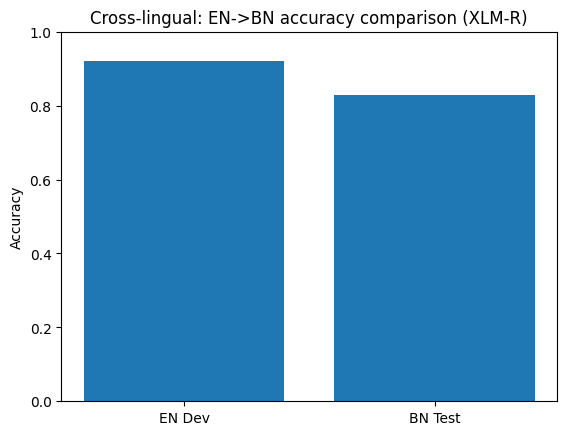

In [15]:
import matplotlib.pyplot as plt

en_acc = float(en_dev_acc) if en_dev_acc is not None else 0.0
bn_acc = float(bn_test_acc) if bn_test_acc is not None else 0.0

print(f"EN Dev accuracy: {en_acc:.4f} | BN Test accuracy: {bn_acc:.4f}")

plt.bar(["EN Dev","BN Test"], [en_acc, bn_acc])
plt.title("Cross-lingual: EN->BN accuracy comparison (XLM-R)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


In [16]:
# --- Load saved model + manual test + robust BN TXT loader + BN evaluation + threshold sweep ---

import os, glob, torch, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

# 1) Fixed saved model directory (your path)
MODEL_DIR = "/kaggle/working/best_xlmr_en2bn_sentiment"
if not (os.path.isdir(MODEL_DIR) and os.path.exists(os.path.join(MODEL_DIR, "config.json"))):
    raise FileNotFoundError(
        f"config.json not found in {MODEL_DIR}\n"
        "Make sure you called trainer.save_model('/kaggle/working/best_xlmr_en2bn_sentiment')."
    )
print(f"✅ Using model dir: {MODEL_DIR}")

# 2) Load model/tokenizer (CPU/GPU auto)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = AutoConfig.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR, config=cfg).to(device)
model.eval()
id2label = getattr(cfg, "id2label", {0:"negative", 1:"positive"})
label2id = {v:k for k,v in id2label.items()}
print("id2label:", id2label)

# 3) Helper: batch predict texts
def batch_predict(texts, batch_size=32, max_length=384, threshold=0.5):
    all_logits = []
    for i in range(0, len(texts), batch_size):
        enc = tokenizer(
            texts[i:i+batch_size],
            truncation=True,
            max_length=max_length,
            padding=True,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            out = model(**enc)
        all_logits.append(out.logits.detach().cpu())
    logits = torch.cat(all_logits, dim=0).numpy()
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    if proba.shape[1] == 2:
        pred = (proba[:, label2id.get("positive", 1)] >= threshold).astype(int)
    else:
        pred = np.argmax(proba, axis=-1)
    return {"pred": pred, "proba": proba, "logits": logits}

# 4) Manual quick test (edit texts as you like)
sample_texts = [
    "I absolutely loved this movie!",
    "This was boring and a waste of time.",
    "ছবিটা অসাধারণ লেগেছে।",
    "গল্পটা খারাপ ছিল।"
]
res = batch_predict(sample_texts)
for t, p, pr in zip(sample_texts, res["pred"], res["proba"]):
    pos_idx = label2id.get("positive", 1)
    neg_idx = label2id.get("negative", 0)
    print(f"[{id2label[int(p)]}]  pos={pr[pos_idx]:.3f}  neg={pr[neg_idx]:.3f}  | {t}")

# 5) Robust loader for Bangla TXT files (one sentence per line)
pos_txt = "/kaggle/input/bengali-sentiment-classification/all_positive_8500.txt"
neg_txt = "/kaggle/input/bengali-sentiment-classification/all_negative_3307.txt"

def load_one_sentence_per_line(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.strip() for ln in f.read().splitlines()]
    lines = [ln for ln in lines if ln]  # drop empty lines
    return pd.DataFrame({"text": lines})

df_bn = None
if os.path.exists(pos_txt) and os.path.exists(neg_txt):
    pos = load_one_sentence_per_line(pos_txt); pos["label"] = 1
    neg = load_one_sentence_per_line(neg_txt); neg["label"] = 0
    df_bn = pd.concat([pos, neg], ignore_index=True)
    print(f"\nLoaded BN dataset: pos={len(pos)}, neg={len(neg)}, total={len(df_bn)}")
elif "df_bn" in globals():
    df_bn = globals()["df_bn"]  # fallback if provided elsewhere
    print(f"\nUsing df_bn from memory: total={len(df_bn)}")
else:
    print("\n[INFO] BN TXT files not found at expected paths; skipping BN eval.")

# 6) Evaluate on BN + threshold sweep + save predictions
if df_bn is not None and {"text", "label"} <= set(df_bn.columns):
    # Evaluate at threshold=0.5
    out = batch_predict(df_bn["text"].tolist(), batch_size=64, max_length=384, threshold=0.5)
    y_true = df_bn["label"].to_numpy()
    y_pred = out["pred"]
    acc  = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    print(f"\nBN @thr=0.5  Acc={acc:.4f}  P={p:.4f}  R={r:.4f}  F1={f1:.4f}")
    print("\nClassification report (BN):\n", classification_report(y_true, y_pred, target_names=["negative","positive"], zero_division=0))
    print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_true, y_pred))

    # Threshold sweep to maximize F1
    proba_pos = out["proba"][:, label2id.get("positive", 1)]
    best_thr, best_f1, best_acc = 0.5, -1, 0.0
    for thr in np.linspace(0.05, 0.95, 181):
        yp = (proba_pos >= thr).astype(int)
        p_, r_, f1_, _ = precision_recall_fscore_support(y_true, yp, average="binary", zero_division=0)
        if f1_ > best_f1:
            best_f1, best_thr, best_acc = f1_, thr, accuracy_score(y_true, yp)
    print(f"\nBN best threshold → thr={best_thr:.3f}, F1={best_f1:.4f}, Acc={best_acc:.4f}")

    # Save predictions
    out_csv = Path("./bn_eval_preds.csv")
    pd.DataFrame({
        "text": df_bn["text"],
        "label": y_true,
        "proba_neg": out["proba"][:, label2id.get("negative", 0)],
        "proba_pos": proba_pos,
        "pred@0.5": y_pred,
        f"pred@{best_thr:.3f}": (proba_pos >= best_thr).astype(int)
    }).to_csv(out_csv, index=False)
    print(f"Saved BN predictions to: {out_csv.resolve()}")
else:
    print("\n[INFO] BN DataFrame missing or lacks ['text','label'] columns; BN evaluation skipped.")


✅ Using model dir: /kaggle/working/best_xlmr_en2bn_sentiment
id2label: {0: 'negative', 1: 'positive'}
[positive]  pos=0.992  neg=0.008  | I absolutely loved this movie!
[negative]  pos=0.025  neg=0.975  | This was boring and a waste of time.
[positive]  pos=0.989  neg=0.011  | ছবিটা অসাধারণ লেগেছে।
[negative]  pos=0.009  neg=0.991  | গল্পটা খারাপ ছিল।

Loaded BN dataset: pos=8500, neg=3307, total=11807

BN @thr=0.5  Acc=0.8285  P=0.8985  R=0.8588  F1=0.8782

Classification report (BN):
               precision    recall  f1-score   support

    negative       0.67      0.75      0.71      3307
    positive       0.90      0.86      0.88      8500

    accuracy                           0.83     11807
   macro avg       0.79      0.80      0.79     11807
weighted avg       0.84      0.83      0.83     11807

Confusion matrix (rows=true, cols=pred):
 [[2482  825]
 [1200 7300]]

BN best threshold → thr=0.125, F1=0.8894, Acc=0.8299
Saved BN predictions to: /kaggle/working/bn_eval_preds.csv